# CAD-DR: CAD Dimensionality Reduction

A deep convolutional autoencoder for dimensionality reduction of 3D CAD models

### Information
1. Ten-layer architecture (5 in encoder + 5 in decoder)
2. Dataset - 1000 STL files
3. Train - 800 models
4. Test - 200 models
5. Epochs - 50
6. Point cloud density - 20k points

### Metrics
1. loss: 0.0180
2. accuracy: 0.9920 (99.20%)
3. val_loss: 0.0120
4. val_accuracy: 0.9948 (99.48%)

### Encoder architecture
- Conv3D(32, (3, 3, 3), activation='selu', padding='same')
- AveragePooling3D((2, 2, 2), padding='same')
- Conv3D(16, (3, 3, 3), activation='selu', padding='same')
- AveragePooling3D((2, 2, 2), padding='same')

#### Run this cell in case you haven't installed the required libraries

In [ ]:
!pip install numpy pandas pyntcloud open3d
!pip install tensorflow[and-cuda]

### Importing all necessary libraries

In [1]:
import numpy as np
import tensorflow as tf
from keras.layers import Input, Conv3D, UpSampling3D, AveragePooling3D
from keras.models import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint
import os
import numpy as np
import pandas as pd
from pyntcloud import PyntCloud
import open3d as o3d
from ConversionUtils import ConversionUtils
from Visualization import Visualization

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


### Converting STL to point cloud

**Execute the following cell if you wish to delete all existing point cloud files in abc-dataset-ply/ directory**

In [20]:
folder_path = "abc-dataset-ply\\"
files = os.listdir(folder_path)

for file in files:
    file_path = os.path.join(folder_path, file)
    if os.path.isfile(file_path):
        try:
            os.remove(file_path)
        except Exception as e:
            print(f"Error deleting {file}: {str(e)}")

**Only execute the next cell if the point cloud files do not exist in abc-dataset-ply/ directory**

In [21]:
files = sorted(ConversionUtils.list_files_in_directory("abc-dataset-stl\\"))
for i in files:
    path = "abc-dataset-stl\\" + i
    ConversionUtils.stl_to_ply(path, 20000)
    print("Converted " + path + " to point-cloud...")

Converted abc-dataset-stl\00060100_8ac42f47a3f048de9ef10333_trimesh_003.stl to point-cloud...
Converted abc-dataset-stl\00060101_be21f48a9a4c4e2fa57af4d9_trimesh_000.stl to point-cloud...
Converted abc-dataset-stl\00060102_be21f48a9a4c4e2fa57af4d9_trimesh_001.stl to point-cloud...
Converted abc-dataset-stl\00060103_253cf6238d99482387fea4cd_trimesh_000.stl to point-cloud...
Converted abc-dataset-stl\00060104_c6d5f07e395640988042fa23_trimesh_000.stl to point-cloud...
Converted abc-dataset-stl\00060105_5a1d8a5bc04b4de8aa4ff583_trimesh_000.stl to point-cloud...
Converted abc-dataset-stl\00060106_5a1d8a5bc04b4de8aa4ff583_trimesh_001.stl to point-cloud...
Converted abc-dataset-stl\00060107_80a398e77fc3459791bb102a_trimesh_000.stl to point-cloud...
Converted abc-dataset-stl\00060108_2f2a2ba6235c452998ce15a3_trimesh_000.stl to point-cloud...
Converted abc-dataset-stl\00060109_8df9324202374b3194bcb822_trimesh_000.stl to point-cloud...
Converted abc-dataset-stl\00060110_93d120dd9fc048f58302f257_

### Converting point cloud to binary voxel arrays

In [2]:
directory = "abc-dataset-ply\\"

files = sorted([filename for filename in os.listdir(directory) if os.path.isfile(os.path.join(directory, filename))])
dataset = []

for i in files:
    path = os.path.join(directory, i)
    binvox = ConversionUtils.convert_to_binvox(path, 64)
    dataset.append(binvox)

In [3]:
print(len(dataset))

1000


### Splitting dataset for training and testing

In [4]:
dataset = np.array(dataset)

train_dataset_length = int(0.8 * len(dataset))
test_set_length = int(0.2 * len(dataset))

train_dataset = dataset[:train_dataset_length]  
test_dataset = dataset[train_dataset_length:]   
print(len(train_dataset), len(test_dataset))

input_shape = (64, 64, 64, 1)

800 200


### Encoder

In [5]:
input_data = Input(shape=input_shape)
x = Conv3D(32, (3, 3, 3), activation='selu', padding='same')(input_data)
x = AveragePooling3D((2, 2, 2), padding='same')(x)
x = Conv3D(16, (3, 3, 3), activation='selu', padding='same')(x)
encoded = AveragePooling3D((2, 2, 2), padding='same')(x)

### Decoder

In [6]:
x = Conv3D(16, (3, 3, 3), activation='selu', padding='same')(encoded)
x = UpSampling3D((2, 2, 2))(x)
x = Conv3D(32, (3, 3, 3), activation='selu', padding='same')(x)
x = UpSampling3D((2, 2, 2))(x)
decoded = Conv3D(1, (3, 3, 3), activation='sigmoid', padding='same')(x)

### Callbacks

#### Early Stopping

In [7]:
early_stopping = EarlyStopping(
    monitor="loss",
    min_delta=0.0001,
    patience=5,
    verbose=0,
    mode="min",
    baseline=None,
    restore_best_weights=False,
)

#### Checkpoint

In [8]:
checkpoint_filepath = 'checkpoints\\checkpoint.weights.h5'
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='loss',
    mode='min',
    save_best_only=True)

### Training autoencoder, prediction done on test dataset

In [9]:
BATCH_SIZE = 10
EPOCHS = 5 # Make it 50 for full training, here we have kept 5 to reduce time

In [10]:
autoencoder = Model(input_data, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

autoencoder.fit(train_dataset, train_dataset, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_data=(test_dataset, test_dataset), callbacks=[early_stopping, model_checkpoint_callback])

Epoch 1/5
80/80 [==============================] - 26s 265ms/step - loss: 0.1233 - accuracy: 0.9675 - val_loss: 0.0736 - val_accuracy: 0.9676
Epoch 2/5
80/80 [==============================] - 23s 286ms/step - loss: 0.0578 - accuracy: 0.9726 - val_loss: 0.0625 - val_accuracy: 0.9697
Epoch 3/5
80/80 [==============================] - 23s 291ms/step - loss: 0.0503 - accuracy: 0.9751 - val_loss: 0.0573 - val_accuracy: 0.9715
Epoch 4/5
80/80 [==============================] - 24s 299ms/step - loss: 0.0460 - accuracy: 0.9773 - val_loss: 0.0546 - val_accuracy: 0.9732
Epoch 5/5
80/80 [==============================] - 24s 298ms/step - loss: 0.0431 - accuracy: 0.9791 - val_loss: 0.0502 - val_accuracy: 0.9756


In [11]:
reconstructed_data = autoencoder.predict(test_dataset, batch_size=BATCH_SIZE)

20/20 [==============================] - 2s 74ms/step


In [12]:
encoder = Model(autoencoder.input, autoencoder.layers[5].output)
encoded_data = encoder.predict(test_dataset, batch_size=BATCH_SIZE)

20/20 [==============================] - 1s 26ms/step


### Saving autoencoder and encoder

In [13]:
autoencoder.save("saved-models\\autoencoder.keras")
encoder.save("saved-models\\encoder.keras")

### Dimensions

In [14]:
print("Shape of input data: ", test_dataset[0].shape)
print("Shape of encoded data: ", encoded_data[0].shape)
print("Shape of reconstructed data: ", reconstructed_data[0].shape)

Shape of input data:  (64, 64, 64)
Shape of encoded data:  (16, 16, 16, 16)
Shape of reconstructed data:  (64, 64, 64, 1)


### Sample reconstruction from test dataset

In [15]:
import matplotlib.pyplot as plt

index = 55 # change this value to visualize different models and their reconstructions

original_sample = test_dataset[index]

reconstructed_sample = reconstructed_data[index].reshape(64, 64, 64)
threshold = 0.35
reconstructed_sample = (reconstructed_sample > threshold).astype(int)

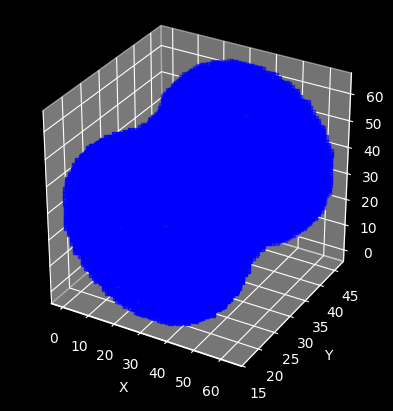

In [16]:
Visualization.matplotlib_visualize_original(original_sample)

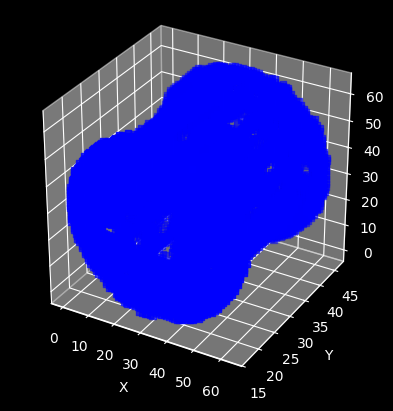

In [17]:
Visualization.matplotlib_visualize_reconstructed(reconstructed_sample)

In [18]:
Visualization.open3d_visualize_original(original_sample)

In [19]:
Visualization.open3d_visualize_reconstructed(reconstructed_sample)

### Visualizing encoded data

In [20]:
sample_encoded_data = encoded_data[index]
print(sample_encoded_data.shape)

(16, 16, 16, 16)


In [21]:
print(sample_encoded_data)

[[[[ 0.17826009 -0.5756376   0.56564957 ... -0.685106   -0.3737963
    -0.51891863]
   [ 0.18851739 -0.7658466   0.62894595 ... -0.87054396 -0.61565655
    -0.66184455]
   [ 0.19360209 -0.7948987   0.637488   ... -0.89111435 -0.64006704
    -0.677581  ]
   ...
   [ 0.19360209 -0.7948987   0.637488   ... -0.89111435 -0.64006704
    -0.677581  ]
   [ 0.2048959  -0.75385046  0.57623273 ... -0.8579583  -0.6331103
    -0.65659213]
   [ 0.17745058 -0.47922403  0.22681104 ... -0.5742617  -0.566945
    -0.4860928 ]]

  [[ 0.27531353 -0.78509825  0.69534814 ... -0.90977436 -0.7057156
    -0.64180785]
   [ 0.3240518  -1.0226855   0.75748104 ... -1.0961957  -0.95149714
    -0.7799631 ]
   [ 0.3337286  -1.0515057   0.7683176  ... -1.1160024  -0.97461116
    -0.79701495]
   ...
   [ 0.3337286  -1.0515057   0.7683176  ... -1.1160024  -0.97461116
    -0.79701495]
   [ 0.33025742 -1.0100981   0.690686   ... -1.0777615  -0.94728416
    -0.7725035 ]
   [ 0.22404753 -0.70198137  0.276469   ... -0.7266542

In [22]:
threshold = 0.35
binary_arrays = (sample_encoded_data >= threshold).astype(int)
print(binary_arrays)

[[[[0 0 1 ... 0 0 0]
   [0 0 1 ... 0 0 0]
   [0 0 1 ... 0 0 0]
   ...
   [0 0 1 ... 0 0 0]
   [0 0 1 ... 0 0 0]
   [0 0 0 ... 0 0 0]]

  [[0 0 1 ... 0 0 0]
   [0 0 1 ... 0 0 0]
   [0 0 1 ... 0 0 0]
   ...
   [0 0 1 ... 0 0 0]
   [0 0 1 ... 0 0 0]
   [0 0 0 ... 0 0 0]]

  [[0 0 1 ... 0 0 0]
   [0 0 1 ... 0 0 0]
   [0 0 1 ... 0 0 0]
   ...
   [0 0 1 ... 0 0 0]
   [0 0 1 ... 0 0 0]
   [0 0 0 ... 0 0 0]]

  ...

  [[0 0 1 ... 0 0 0]
   [0 0 1 ... 0 0 0]
   [0 0 1 ... 0 0 0]
   ...
   [1 0 1 ... 0 0 0]
   [0 0 1 ... 0 0 0]
   [0 0 0 ... 0 0 0]]

  [[0 0 1 ... 0 0 0]
   [0 0 1 ... 0 0 0]
   [1 0 1 ... 0 0 0]
   ...
   [1 0 1 ... 0 0 0]
   [1 0 1 ... 0 0 0]
   [0 0 0 ... 0 0 0]]

  [[0 0 1 ... 0 0 0]
   [1 0 1 ... 0 0 0]
   [1 0 1 ... 0 0 0]
   ...
   [1 0 1 ... 0 0 0]
   [0 0 1 ... 0 0 0]
   [0 0 0 ... 0 0 0]]]


 [[[0 0 1 ... 0 0 0]
   [0 0 1 ... 0 0 0]
   [0 0 1 ... 0 0 0]
   ...
   [0 0 1 ... 0 0 0]
   [0 0 1 ... 0 0 0]
   [0 0 0 ... 0 0 0]]

  [[0 0 1 ... 0 0 0]
   [0 0 1 ... 0 0 0]
   [

C:\Users\hrish\AppData\Local\Temp\ipykernel_20064\4175828760.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab20', len(binary_arrays))
C:\Users\hrish\AppData\Local\Temp\ipykernel_20064\4175828760.py:12: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(x, y, z, c=colors(i), marker='o', s=20, label=f'Channel {i + 1}')


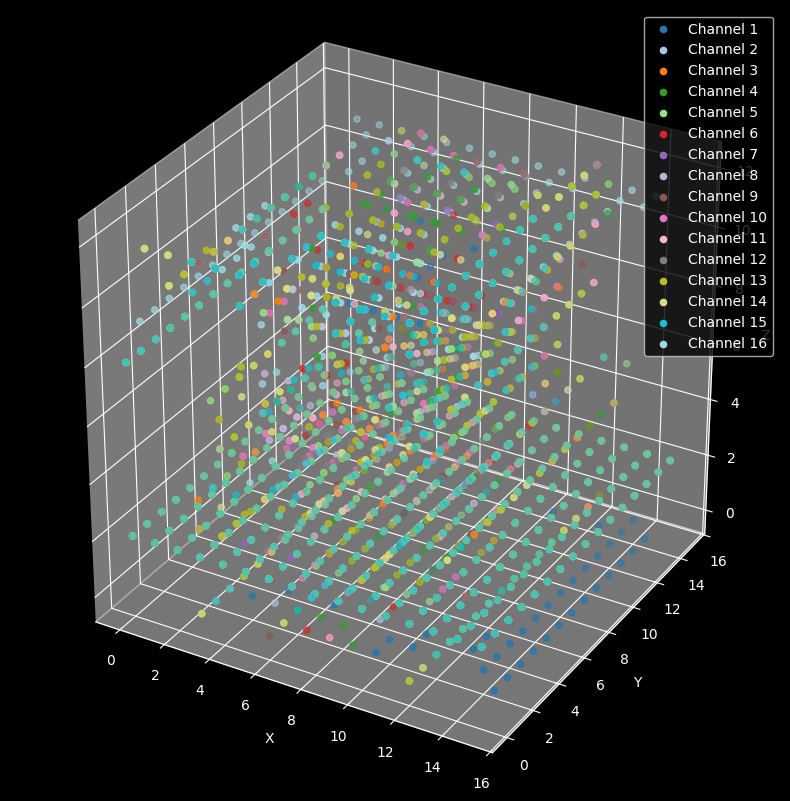

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

colors = plt.cm.get_cmap('tab20', len(binary_arrays))

for i, binary_array in enumerate(binary_arrays):
    x, y, z = np.where(binary_array == 1)
    ax.scatter(x, y, z, c=colors(i), marker='o', s=20, label=f'Channel {i + 1}')

ax.set_box_aspect([1, 1, 1])

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

ax.legend()

plt.show()